## Importing Essential Libraries

In [23]:
import numpy as np
import h5py
import math
import os
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

warnings.filterwarnings("ignore")

In [3]:
data_path = "/kaggle/input/datasettt/Quark Gluon Data Set.hdf5"

## Data Preprocessing

In [5]:
with h5py.File(data_path, 'r') as f:
    jet_images = f['X_jets'][0:6400] 

In [6]:
track_mean = np.mean(jet_images[:,:,:,0])
track_std = np.std(jet_images[:,:,:,0])

ecal_mean = np.mean(jet_images[:,:,:,1])
ecal_std = np.std(jet_images[:,:,:,1])

hcal_mean = np.mean(jet_images[:,:,:,2])
hcal_std = np.std(jet_images[:,:,:,2])

channel_means = [track_mean, ecal_mean, hcal_mean]
channel_stds = [track_std, ecal_std, hcal_std]

norm_track = (jet_images[:,:,:,0] - track_mean) / track_std
norm_ecal = (jet_images[:,:,:,1] - ecal_mean) / ecal_std
norm_hcal = (jet_images[:,:,:,2] - hcal_mean) / hcal_std

combined_channels = norm_track + norm_ecal + norm_hcal
combined_channels = np.expand_dims(combined_channels, axis=-1)

In [7]:
def display_samples(images, num_samples=3):
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20, 20))
    for i in range(num_samples):
        img_display = axes[i].imshow(images[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title(f'Combined Sample {i+1}')
        fig.colorbar(img_display, ax=axes[i], shrink=0.25)
    plt.show()

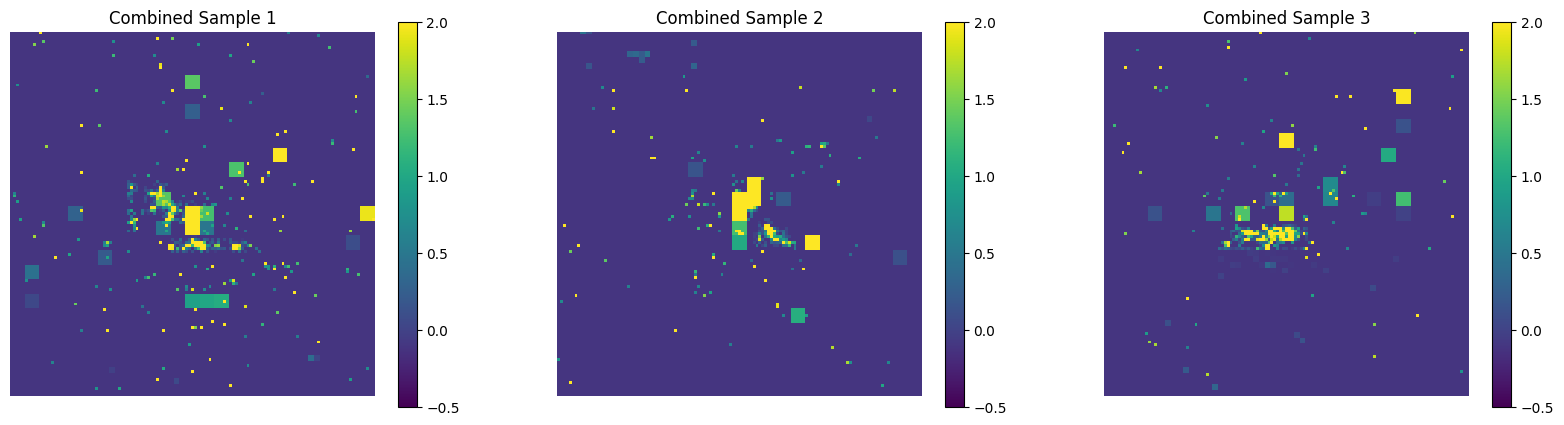

In [8]:
display_samples(combined_channels)

In [9]:
class JetImageDataset(Dataset):
    def __init__(self, image_data, transform=None):
        self.images = image_data
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [10]:
def resize_images(images, target_size):
    from tensorflow.keras.preprocessing.image import smart_resize
    resized = np.zeros((images.shape[0], target_size, target_size, 3))
    for i in range(images.shape[0]):
        resized[i] = smart_resize(images[i], (target_size, target_size))
    return resized

In [11]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
jet_images_resized = resize_images(jet_images, IMAGE_SIZE)
print(f"Resized images shape: {jet_images_resized.shape}")

Resized images shape: (6400, 64, 64, 3)


In [12]:
def min_max_normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val + 1e-10)  #added small epsilon to avoid division by zero

image_transforms = transforms.Compose([
    transforms.Lambda(min_max_normalize),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1]
])

In [13]:
dataset = JetImageDataset(image_data=jet_images_resized, transform=image_transforms)

In [14]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [15]:
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Data type: {type(sample_batch)}")
print(f"Loader type: {type(train_loader)}")

Sample batch shape: torch.Size([128, 3, 64, 64])
Data type: <class 'torch.Tensor'>
Loader type: <class 'torch.utils.data.dataloader.DataLoader'>


# Diffusion Model Implementation
## Forward Process

In [16]:
def create_beta_schedule(timesteps, start_beta=0.00000001, end_beta=0.000002):
    """Create a linear beta schedule for the diffusion process."""
    return torch.linspace(start_beta, end_beta, timesteps)

def extract_values_at_timestep(values, t, shape):
    """Helper function to extract values at a specific timestep."""
    batch_size = t.shape[0]
    out = values.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(shape) - 1))).to(t.device)

def apply_forward_diffusion(x_0, t, device="cpu"):
    """Add noise to an image according to the diffusion process at timestep t."""
    noise = torch.randn_like(x_0)
    
    sqrt_alphas_cumprod_t = extract_values_at_timestep(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract_values_at_timestep(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    noisy_image = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + \
                  sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
                  
    return noisy_image, noise.to(device)

In [17]:
TIMESTEPS = 300
betas = create_beta_schedule(timesteps=TIMESTEPS)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [18]:
for batch_idx, batch in enumerate(train_loader):
    print(f"Train batch {batch_idx}, shape: {batch.shape}")
    if batch_idx >= 2: 
        break

for batch_idx, batch in enumerate(test_loader):
    print(f"Test batch {batch_idx}, shape: {batch.shape}")
    if batch_idx >= 2: 
        break

Train batch 0, shape: torch.Size([128, 3, 64, 64])
Train batch 1, shape: torch.Size([128, 3, 64, 64])
Train batch 2, shape: torch.Size([128, 3, 64, 64])
Test batch 0, shape: torch.Size([128, 3, 64, 64])
Test batch 1, shape: torch.Size([128, 3, 64, 64])
Test batch 2, shape: torch.Size([128, 3, 64, 64])


In [19]:
def visualize_tensor_image(image):
    """Convert a tensor image back to a displayable NumPy array."""
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), 
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  
        transforms.Lambda(lambda t: t.numpy()),
    ])
    
    if len(image.shape) == 4:
        image = image[0]
        
    image_np = reverse_transforms(image)
    
    combined = np.sum(image_np, axis=-1, keepdims=True)
    
    plt.imshow(combined[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')

In [20]:
def visualize_diffusion_process(image, timesteps):
    plt.figure(figsize=(20, 4)) 
    plt.axis('off')
    num_images = 10
    stepsize = int(timesteps / num_images)
    
    plt.subplot(1, num_images + 1, 1)
    visualize_tensor_image(image)
    
    for idx in range(0, timesteps, stepsize):
        t = torch.tensor([idx], dtype=torch.int64)
        plt.subplot(1, num_images + 1, (idx // stepsize) + 2)
        noisy_image, _ = apply_forward_diffusion(image, t)
        visualize_tensor_image(noisy_image)
    
    plt.tight_layout()
    plt.show()

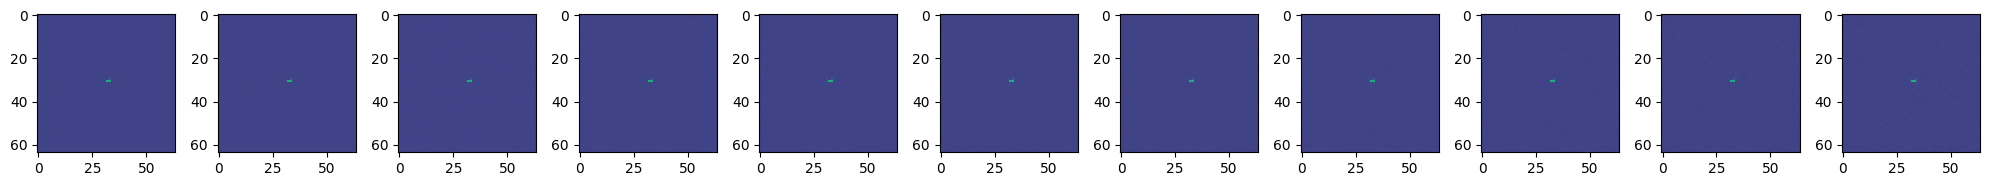

In [24]:
sample_image = next(iter(train_loader))
visualize_diffusion_process(sample_image, TIMESTEPS)

## Backward Process (U-Net Model)

In [25]:
class DiffusionBlock(nn.Module):
    """Building block for the U-Net architecture."""
    def __init__(self, in_channels, out_channels, time_embedding_dim, upsample=False):
        super().__init__()
        self.time_projection = nn.Linear(time_embedding_dim, out_channels)
        
        if upsample:
            self.conv1 = nn.Conv2d(2 * in_channels, out_channels, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.activation = nn.ReLU()
        
    def forward(self, x, t):
        h = self.activation(self.bn1(self.conv1(x)))
    
        time_emb = self.activation(self.time_projection(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        
        h = h + time_emb
        
        h = self.activation(self.bn2(self.conv2(h)))
        
        return self.transform(h)

In [26]:
class SinusoidalTimeEmbedding(nn.Module):
    """Sinusoidal time embedding as described in the diffusion papers."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [27]:
class DiffusionUNet(nn.Module):
    """U-Net architecture for diffusion models."""
    def __init__(self):
        super().__init__()
        
        input_channels = 3
        time_embedding_dim = 32
        
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        
        self.time_embedding = nn.Sequential(
            SinusoidalTimeEmbedding(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.ReLU()
        )
        
        self.input_projection = nn.Conv2d(input_channels, down_channels[0], kernel_size=3, padding=1)
        
        self.down_blocks = nn.ModuleList([
            DiffusionBlock(down_channels[i], down_channels[i+1], time_embedding_dim)
            for i in range(len(down_channels)-1)
        ])
        
        self.up_blocks = nn.ModuleList([
            DiffusionBlock(up_channels[i], up_channels[i+1], time_embedding_dim, upsample=True)
            for i in range(len(up_channels)-1)
        ])
        
        self.output_projection = nn.Conv2d(up_channels[-1], input_channels, kernel_size=1)
        
    def forward(self, x, timestep):
        t_emb = self.time_embedding(timestep)
        
        x = x.float()
        
        h = self.input_projection(x)
        
        skip_connections = []
        
        for down_block in self.down_blocks:
            h = down_block(h, t_emb)
            skip_connections.append(h)
        
        for up_block in self.up_blocks:
            skip = skip_connections.pop()
            h = torch.cat((h, skip), dim=1)
            h = up_block(h, t_emb)
        
        return self.output_projection(h)

In [28]:
diffusion_model = DiffusionUNet()

## Training Functions

In [29]:
def compute_loss(model, x_0, t, device):
    """Calculate diffusion loss for training."""
    x_noisy, original_noise = apply_forward_diffusion(x_0, t, device)
    
    noise_prediction = model(x_noisy, t)
    
    return F.l1_loss(original_noise, noise_prediction)

@torch.no_grad()
def denoise_sample(x, t, model):
    """Denoise the image at a specific timestep using the model."""
    beta_t = extract_values_at_timestep(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract_values_at_timestep(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alpha_t = extract_values_at_timestep(sqrt_recip_alphas, t, x.shape)
    
    predicted_noise = model(x, t)
    
    model_mean = sqrt_recip_alpha_t * (
        x - beta_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    
    posterior_variance_t = extract_values_at_timestep(posterior_variance, t, x.shape)
    
    if t[0] == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def generate_and_plot_sample(model, device, timesteps=TIMESTEPS):
    """Generate a new image by starting from random noise and denoising."""
    img_size = IMAGE_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(timesteps / num_images)
    
    for i in range(timesteps)[::-1]: 
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = denoise_sample(img, t, model)
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, math.ceil((timesteps - i) / stepsize))
            visualize_tensor_image(img.detach().cpu())
    
    plt.show()

## Training Loop

In [30]:
def train_diffusion_model(model, train_loader, epochs, device, learning_rate=0.001):
    """Train the diffusion model."""
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            batch = batch.to(device)
            
            t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
            
            loss = compute_loss(model, batch, t, device)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if step % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Step {step}/{len(train_loader)} | Loss: {loss.item():.6f}")
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} completed | Avg Loss: {epoch_loss:.6f}")
        
        if (epoch + 1) % 5 == 0:
            print("Generating sample image...")
            generate_and_plot_sample(model, device)
            
    return model

In [31]:
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Epoch 1/20 | Step 0/40 | Loss: 0.804913
Epoch 1/20 | Step 10/40 | Loss: 0.791007
Epoch 1/20 | Step 20/40 | Loss: 0.683839
Epoch 1/20 | Step 30/40 | Loss: 0.554618
Epoch 1/20 completed | Avg Loss: 0.669207
Epoch 2/20 | Step 0/40 | Loss: 0.485265
Epoch 2/20 | Step 10/40 | Loss: 0.425564
Epoch 2/20 | Step 20/40 | Loss: 0.380756
Epoch 2/20 | Step 30/40 | Loss: 0.343908
Epoch 2/20 completed | Avg Loss: 0.387131
Epoch 3/20 | Step 0/40 | Loss: 0.317085
Epoch 3/20 | Step 10/40 | Loss: 0.305212
Epoch 3/20 | Step 20/40 | Loss: 0.315897
Epoch 3/20 | Step 30/40 | Loss: 0.294424
Epoch 3/20 completed | Avg Loss: 0.307119
Epoch 4/20 | Step 0/40 | Loss: 0.311279
Epoch 4/20 | Step 10/40 | Loss: 0.297479
Epoch 4/20 | Step 20/40 | Loss: 0.280912
Epoch 4/20 | Step 30/40 | Loss: 0.278092
Epoch 4/20 completed | Avg Loss: 0.281714
Epoch 5/20 | Step 0/40 | Loss: 0.266323
Epoch 5/20 | Step 10/40 | Loss: 0.274398
Epoch 5/20 | Step 20/40 | Loss: 0.269762
Epoch 5/20 | Step 30/40 | Loss: 0.246057
Epoch 5/20 comple

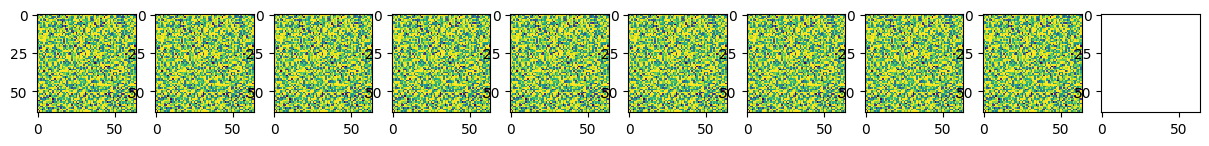

Epoch 6/20 | Step 0/40 | Loss: 0.247813
Epoch 6/20 | Step 10/40 | Loss: 0.262101
Epoch 6/20 | Step 20/40 | Loss: 0.252459
Epoch 6/20 | Step 30/40 | Loss: 0.272179
Epoch 6/20 completed | Avg Loss: 0.253950
Epoch 7/20 | Step 0/40 | Loss: 0.231059
Epoch 7/20 | Step 10/40 | Loss: 0.245120
Epoch 7/20 | Step 20/40 | Loss: 0.259674
Epoch 7/20 | Step 30/40 | Loss: 0.278161
Epoch 7/20 completed | Avg Loss: 0.247224
Epoch 8/20 | Step 0/40 | Loss: 0.239662
Epoch 8/20 | Step 10/40 | Loss: 0.266328
Epoch 8/20 | Step 20/40 | Loss: 0.234677
Epoch 8/20 | Step 30/40 | Loss: 0.218566
Epoch 8/20 completed | Avg Loss: 0.245067
Epoch 9/20 | Step 0/40 | Loss: 0.227402
Epoch 9/20 | Step 10/40 | Loss: 0.218875
Epoch 9/20 | Step 20/40 | Loss: 0.237660
Epoch 9/20 | Step 30/40 | Loss: 0.218250
Epoch 9/20 completed | Avg Loss: 0.230272
Epoch 10/20 | Step 0/40 | Loss: 0.240554
Epoch 10/20 | Step 10/40 | Loss: 0.240312
Epoch 10/20 | Step 20/40 | Loss: 0.220009
Epoch 10/20 | Step 30/40 | Loss: 0.218929
Epoch 10/20 c

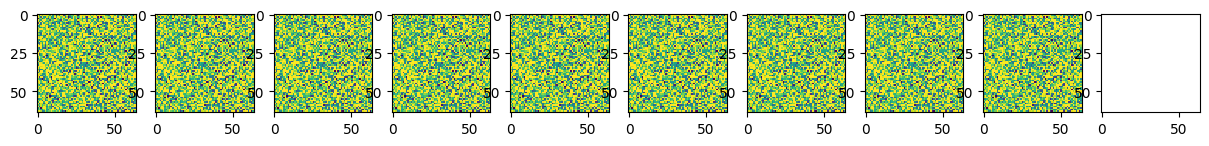

Epoch 11/20 | Step 0/40 | Loss: 0.244630
Epoch 11/20 | Step 10/40 | Loss: 0.210248
Epoch 11/20 | Step 20/40 | Loss: 0.241199
Epoch 11/20 | Step 30/40 | Loss: 0.224083
Epoch 11/20 completed | Avg Loss: 0.232251
Epoch 12/20 | Step 0/40 | Loss: 0.210224
Epoch 12/20 | Step 10/40 | Loss: 0.222269
Epoch 12/20 | Step 20/40 | Loss: 0.206000
Epoch 12/20 | Step 30/40 | Loss: 0.228215
Epoch 12/20 completed | Avg Loss: 0.235992
Epoch 13/20 | Step 0/40 | Loss: 0.242541
Epoch 13/20 | Step 10/40 | Loss: 0.213779
Epoch 13/20 | Step 20/40 | Loss: 0.191346
Epoch 13/20 | Step 30/40 | Loss: 0.216240
Epoch 13/20 completed | Avg Loss: 0.224371
Epoch 14/20 | Step 0/40 | Loss: 0.221425
Epoch 14/20 | Step 10/40 | Loss: 0.215055
Epoch 14/20 | Step 20/40 | Loss: 0.200439
Epoch 14/20 | Step 30/40 | Loss: 0.201807
Epoch 14/20 completed | Avg Loss: 0.210697
Epoch 15/20 | Step 0/40 | Loss: 0.217528
Epoch 15/20 | Step 10/40 | Loss: 0.212824
Epoch 15/20 | Step 20/40 | Loss: 0.206416
Epoch 15/20 | Step 30/40 | Loss: 0.

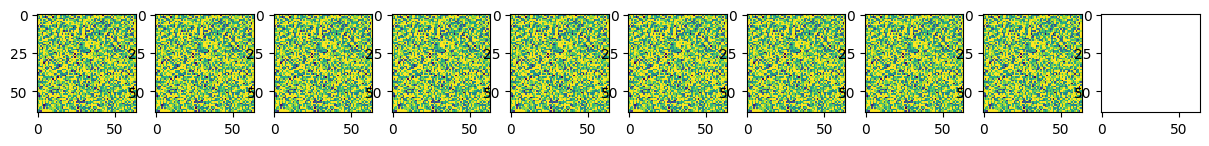

Epoch 16/20 | Step 0/40 | Loss: 0.205433
Epoch 16/20 | Step 10/40 | Loss: 0.191556
Epoch 16/20 | Step 20/40 | Loss: 0.200396
Epoch 16/20 | Step 30/40 | Loss: 0.190490
Epoch 16/20 completed | Avg Loss: 0.207969
Epoch 17/20 | Step 0/40 | Loss: 0.197170
Epoch 17/20 | Step 10/40 | Loss: 0.206260
Epoch 17/20 | Step 20/40 | Loss: 0.203102
Epoch 17/20 | Step 30/40 | Loss: 0.212862
Epoch 17/20 completed | Avg Loss: 0.204080
Epoch 18/20 | Step 0/40 | Loss: 0.184015
Epoch 18/20 | Step 10/40 | Loss: 0.180975
Epoch 18/20 | Step 20/40 | Loss: 0.194890
Epoch 18/20 | Step 30/40 | Loss: 0.189913
Epoch 18/20 completed | Avg Loss: 0.196776
Epoch 19/20 | Step 0/40 | Loss: 0.187980
Epoch 19/20 | Step 10/40 | Loss: 0.204662
Epoch 19/20 | Step 20/40 | Loss: 0.182752
Epoch 19/20 | Step 30/40 | Loss: 0.196857
Epoch 19/20 completed | Avg Loss: 0.203993
Epoch 20/20 | Step 0/40 | Loss: 0.202712
Epoch 20/20 | Step 10/40 | Loss: 0.197217
Epoch 20/20 | Step 20/40 | Loss: 0.193534
Epoch 20/20 | Step 30/40 | Loss: 0.

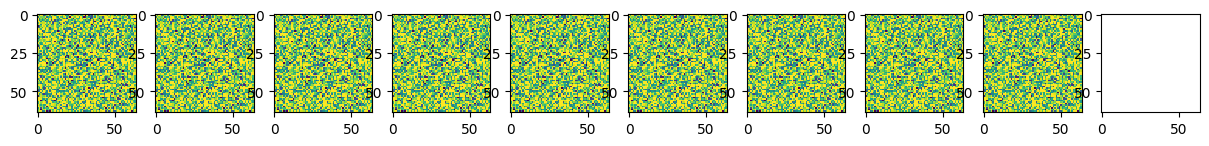

In [32]:
trained_model = train_diffusion_model(diffusion_model, train_loader, EPOCHS, device)

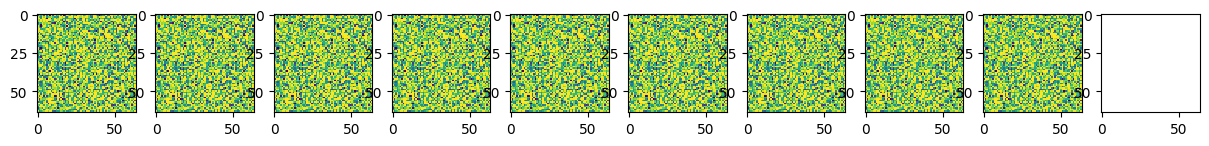

In [33]:
generate_and_plot_sample(trained_model, device)

## Summary

+ When handling physics-based dataset imagery rather than standard RGB images, preprocessing requires special attention to preserve essential physical attributes. In our experiment, careful pixel value scaling was essential to maintain critical image features.

+ While metrics such as SSIM and PSNR could theoretically evaluate the comparison between original and reconstructed events, our backward process failed to produce meaningful representations.

+ We found beta scheduler selection to be a key factor in our process. Through manual image inspection, we implemented a linear beta schedule with customized start and end values.

+ Additional research and refinement are necessary to develop effective diffusion models for image-based physical quark/gluon data. Future work should investigate varied diffusion schedules, preprocessing approaches, and model architectures better suited to capturing the data's underlying physical characteristics.

## References

+ Diffusion paper: https://arxiv.org/pdf/2006.11239
+ https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch
+ https://medium.com/@brianpulfer/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1